In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Getting the data

As always, let's import our last updated data.

In [2]:
from utils import load_datasets

gru_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "gru")
gru_train_set, gru_val_set, gru_test_set = load_datasets(folder=gru_data_folder)

grubert_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "grubert")
grubert_train_set, grubert_val_set, grubert_test_set = load_datasets(folder=grubert_data_folder)

# Base Case Training  

In [3]:
seeds = [42, 69, 420, 1, 3]

# Training

We start by defining all the params that characterize our training.

In [4]:
from ModelOps import bce
import vocabulary as v

# Model class and Session Name
MODEL_CLASS = 'gru'
SESSION_NAME = 'base_case'

# Fixed params
EPOCHS = 30
SEEDS = [42, 69, 420, 1, 3]
EMBEDDING_SIZE = 100
TOKENIZER = v.BaseTokenizer()
MAX_LEN = 50

# Grid Search params
LOSS_FN = bce
LR = 'cosine'
BATCH_SIZE = 8
LABEL_SMOOTHING = 0.1
SCALE_GRAD_BY_FREQ = False # True
GRU_HIDDEN_SIZE = 32 # 128 256
NUM_GRU_LAYERS = 2
GRU_DROPOUT = 0.2

# Enrichment params
HASHTAG_SEGMENTATION = False
POS_TAGS_ENRICHMENT = None
NUM_POS_TAGS = None
HASHTAG_ENRICHMENT = False

Let us set everything we need for training: vocabulary, model params, datasets and dataloader.

In [5]:
from gensim.models import KeyedVectors
from torch.utils.data import DataLoader
from CustomDataset import GRUDataset

# Vocabulary
embedding_model_path = os.path.join(parent_dir, "embedding_models", "italian_word2vec_100.bin")
embedding_model = KeyedVectors.load_word2vec_format(embedding_model_path, binary=True)
vocab = v.Vocabulary(
    dataset=gru_train_set,
    embedding_model=embedding_model,
    embedding_size=EMBEDDING_SIZE,
    tokenizer=TOKENIZER
)
vocab.create_vocabulary()

# Model params
model_init_kwargs = {
    'embedding_matrix': vocab.embedding_matrix,
    'scale_grad_by_freq': SCALE_GRAD_BY_FREQ, # True,
    'gru_hidden_size': GRU_HIDDEN_SIZE, # 128, # 256,
    'num_gru_layers': NUM_GRU_LAYERS,
    'gru_dropout': GRU_DROPOUT,
    'text_enrichment': HASHTAG_ENRICHMENT,
    'num_tags': NUM_POS_TAGS,
}

# Datasets
training_dataset = GRUDataset(
    dataframe=gru_train_set,
    vocabulary=vocab,
    tokenizer=TOKENIZER,
    max_len=MAX_LEN,
    hashtag_segmentation=HASHTAG_SEGMENTATION,
    pos_tags=POS_TAGS_ENRICHMENT,
    text_enrichment=HASHTAG_ENRICHMENT
)

validation_dataset = GRUDataset(
    dataframe=gru_val_set,
    vocabulary=vocab,
    tokenizer=TOKENIZER,
    max_len=MAX_LEN,
    hashtag_segmentation=HASHTAG_SEGMENTATION,
    pos_tags=POS_TAGS_ENRICHMENT,
    text_enrichment=HASHTAG_ENRICHMENT
)

# Dataloaders
training_loader = DataLoader(
    dataset=training_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True
)

Importato package text_enrichment.


In [6]:
from training_session import TrainingSession

ts = TrainingSession(
    model_class=MODEL_CLASS,
    model_init_kwargs=model_init_kwargs,
    training_loader=training_loader,
    validation_loader=validation_loader,
    loss_fn=LOSS_FN,
    lr=LR,
    session_name=SESSION_NAME,
    seeds=seeds
)

In [8]:
ts.train(EPOCHS, verbose=False)

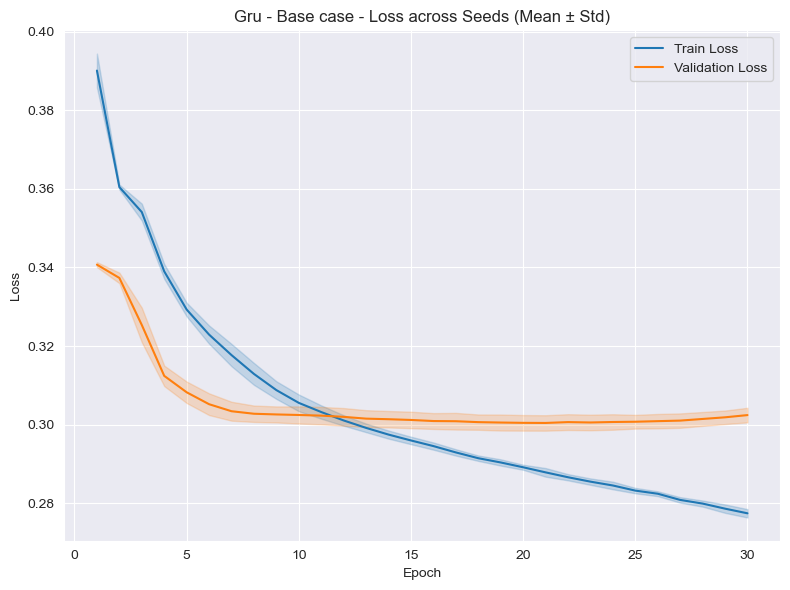

In [14]:
plot_folder = os.path.join(parent_dir, "6_training", "plots")

ts.plot(to_folder=plot_folder)